# Download Dataset

In [4]:
! wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rscbjbr9sj-2.zip

--2022-04-23 21:11:50--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rscbjbr9sj-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.112.56
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.112.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7030149142 (6.5G) [application/octet-stream]
Saving to: ‘rscbjbr9sj-2.zip’

rscbjbr9sj-2.zip    100%[===================>]   6.55G  30.4MB/s    in 3m 44s  

2022-04-23 21:15:34 (30.0 MB/s) - ‘rscbjbr9sj-2.zip’ saved [7030149142/7030149142]



In [ ]:
! unzip rscbjbr9sj-2.zip
! unzip ChestXRay2017.zip
! tar –xvzf OCT2017.tar.gz
! rm -rf *.zip
! rm -rf *.tar.gz
! rm -rf chest_xray/train/NORMAL/.DS_Store
! rm -rf chest_xray/train/PNEUMONIA/.DS_Store
! rm -rf chest_xray/test/NORMAL/.DS_Store
! rm -rf chest_xray/test/PNEUMONIA/.DS_Store

# Data Exploration

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import random
import cv2
%matplotlib inline

sns.set_style("whitegrid")
random.seed(30)

In [7]:
! ls chest_xray/train/NORMAL | wc -l
! ls chest_xray/train/PNEUMONIA | wc -l

1349
3883


In [8]:
! ls chest_xray/test/NORMAL | wc -l
! ls chest_xray/test/PNEUMONIA | wc -l

234
390


In [9]:
normal = []
for choice in random.choices(os.listdir("chest_xray/train/NORMAL"), k=5):
  img = mpimg.imread(f"chest_xray/train/NORMAL/{choice}")
  normal.append(img)

In [10]:
pneumonia = []
for choice in random.choices(os.listdir("chest_xray/train/PNEUMONIA"), k=5):
  img = mpimg.imread(f"chest_xray/train/PNEUMONIA/{choice}")
  pneumonia.append(img)

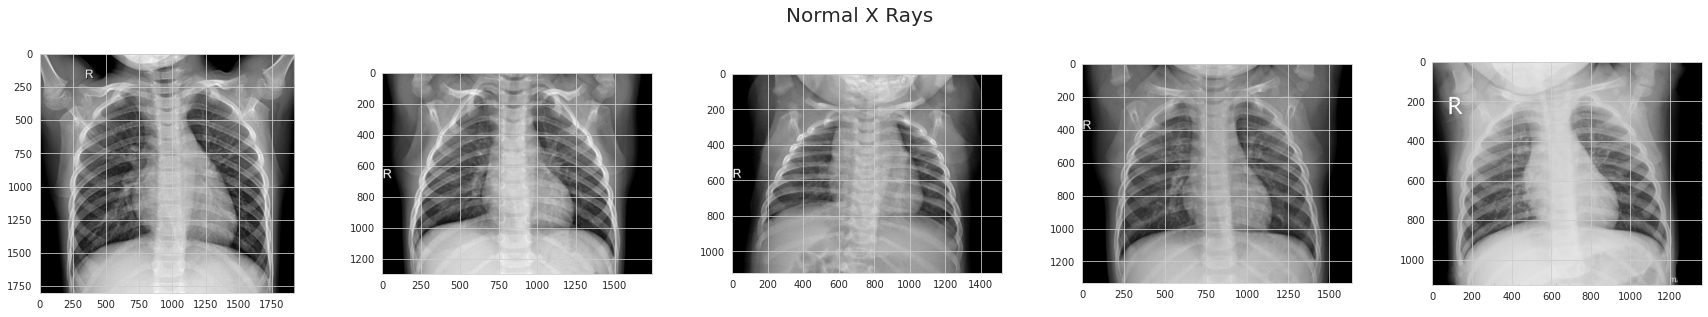

In [11]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
plt.tight_layout(pad=5.0)
title = 'Normal X Rays'
fig.suptitle(title, fontsize=20)

ax[0].imshow(normal[0], cmap="gray")
ax[1].imshow(normal[1], cmap="gray")
ax[2].imshow(normal[2], cmap="gray")
ax[3].imshow(normal[3], cmap="gray")
ax[4].imshow(normal[4], cmap="gray")


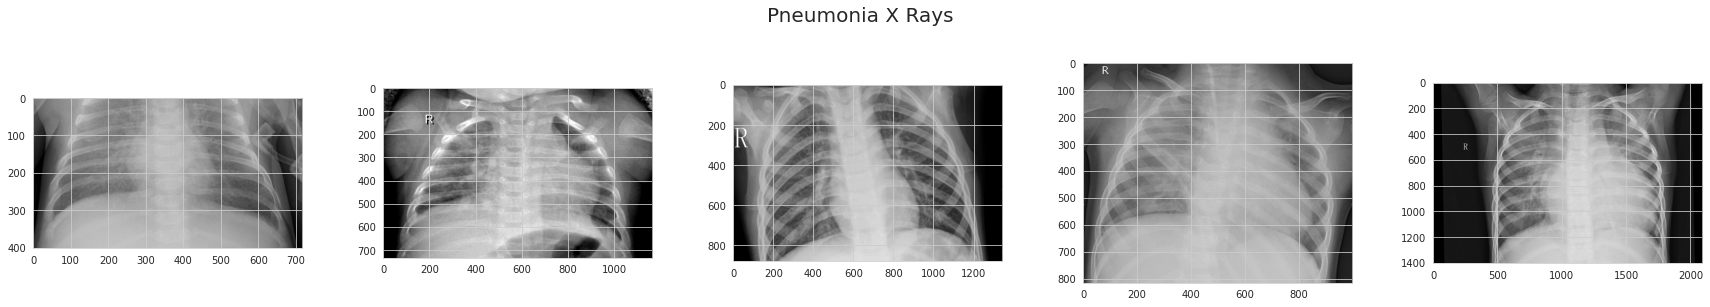

In [12]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
plt.tight_layout(pad=5.0)
title = 'Pneumonia X Rays'
fig.suptitle(title, fontsize=20)

ax[0].imshow(pneumonia[0], cmap="gray")
ax[1].imshow(pneumonia[1], cmap="gray")
ax[2].imshow(pneumonia[2], cmap="gray")
ax[3].imshow(pneumonia[3], cmap="gray")
ax[4].imshow(pneumonia[4], cmap="gray")


# Creating Validation Set and Data Augmentation

The training set is divided in two parts:


1.   Training Part (90%)
2.   Validation (10%)

Data augmentation is done on both training and test sets

In [13]:
from keras.preprocessing.image import ImageDataGenerator

In [14]:
! mkdir chest_xray/val
! mkdir chest_xray/val/NORMAL
! mkdir chest_xray/val/PNEUMONIA

In [15]:
random.seed(2020)
for choice in random.choices(os.listdir("chest_xray/train/NORMAL"), k=135):
  src = f"chest_xray/train/NORMAL/{choice}"
  dest = f"chest_xray/val/NORMAL/{choice}"
  try:
    os.rename(src, dest)
  except:
    print(choice)

IM-0531-0001.jpeg
NORMAL2-IM-0414-0001.jpeg
IM-0199-0001.jpeg


In [ ]:
random.seed(2020)
for choice in random.choices(os.listdir("chest_xray/train/PNEUMONIA"), k=388):
  src = f"chest_xray/train/PNEUMONIA/{choice}"
  dest = f"chest_xray/val/PNEUMONIA/{choice}"
  try:
    os.rename(src, dest)
  except:
    print(choice)

In [17]:
datagen = ImageDataGenerator(rescale=1/255,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2,
                           zoom_range=0.2, 
                           horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
image_height = 200
image_width = 200
batch_size = 10
no_of_epochs  = 100

In [19]:
train_set = datagen.flow_from_directory('chest_xray/train',target_size=(image_width, image_height),batch_size=batch_size,class_mode='binary')
val_set = datagen.flow_from_directory('chest_xray/val',target_size=(image_width, image_height),batch_size=batch_size,class_mode='binary')
test_set = test_datagen.flow_from_directory('chest_xray/test',target_size=(image_width, image_height),batch_size=batch_size,class_mode='binary')

Found 4727 images belonging to 2 classes.
Found 505 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Creating the Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

In [21]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.build(input_shape=(None, 200, 200, 3))

In [22]:
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
#opt = SGD()
model.compile(loss='binary_crossentropy',
            optimizer=opt, metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [24]:
reduce_learning_rate = ReduceLROnPlateau(monitor='accuracy',
                                         factor=0.5,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.000000001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In [25]:
history = model.fit(train_set,
          validation_data=val_set,
          epochs=100, batch_size=10)

Epoch 1/100
473/473 [==============================] - 105s 197ms/step - loss: 0.5745 - accuracy: 0.7417 - val_loss: 0.5944 - val_accuracy: 0.7386
Epoch 2/100
473/473 [==============================] - 93s 196ms/step - loss: 0.5069 - accuracy: 0.7569 - val_loss: 0.4547 - val_accuracy: 0.7545
Epoch 3/100
473/473 [==============================] - 93s 197ms/step - loss: 0.3783 - accuracy: 0.8200 - val_loss: 0.3751 - val_accuracy: 0.8257
Epoch 4/100
473/473 [==============================] - 93s 196ms/step - loss: 0.3261 - accuracy: 0.8500 - val_loss: 0.2581 - val_accuracy: 0.8911
Epoch 5/100
473/473 [==============================] - 93s 196ms/step - loss: 0.2984 - accuracy: 0.8680 - val_loss: 0.2722 - val_accuracy: 0.8931
Epoch 6/100
473/473 [==============================] - 93s 196ms/step - loss: 0.3076 - accuracy: 0.8616 - val_loss: 0.2480 - val_accuracy: 0.8970
Epoch 7/100
473/473 [==============================] - 93s 196ms/step - loss: 0.2855 - accuracy: 0.8741 - val_loss: 0.2611 

In [26]:
model.save('mycnn1.h5')
model.save('mycnn1')

INFO:tensorflow:Assets written to: mycnn1/assets


# Model Evaluation

In [28]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

In [27]:
print("Training Set:")
train_acc = model.evaluate(train_set)

print("Test Set:")
test_acc = model.evaluate(test_set)

Training Set:
473/473 [==============================] - 82s 174ms/step - loss: 0.1052 - accuracy: 0.9600
Test Set:
63/63 [==============================] - 6s 94ms/step - loss: 0.2628 - accuracy: 0.9119


## Training Set Confusion Matrix

In [29]:
train_orig = []
for i in range(4727//10 + 1):
    for label in train_set[i][1]:
        train_orig.append(label)
        
train_orig = np.array(train_orig)

In [30]:
train_pred = model.predict(train_set)
train_pred = np.around(train_pred)

<Figure size 432x288 with 0 Axes>

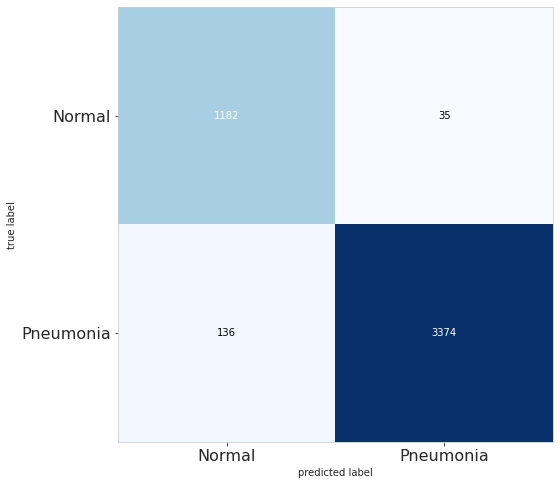

In [31]:
cm  = confusion_matrix(train_orig, train_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [32]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn+fp)

print("Sensitivity (Recall): {:.4f}".format(recall))
print("Specificity: {:.4f}".format(specificity))
print("Precision: {:.4f}".format(precision))

Sensitivity (Recall): 0.9613
Specificity: 0.9712
Precision: 0.9897


In [33]:
tn

1182

## Test Set Confusion Matrix

In [34]:
test_orig = []
for i in range(624//10 + 1):
    for label in test_set[i][1]:
        test_orig.append(label)
        
test_orig = np.array(test_orig)

In [35]:
test_pred = model.predict(test_set)
test_pred = np.around(test_pred)

<Figure size 432x288 with 0 Axes>

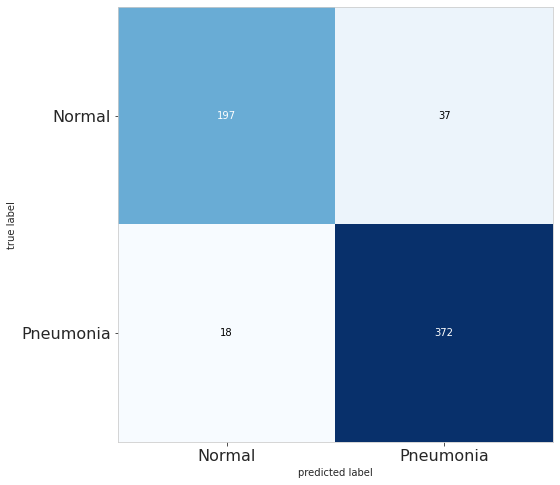

In [36]:
cm  = confusion_matrix(test_orig, test_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [37]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity=tn/(tn+fp)

print("Sensitivity (Recall): {:.4f}".format(recall))
print("Specificity: {:.4f}".format(specificity))
print("Precision: {:.4f}".format(precision))

Sensitivity (Recall): 0.9538
Specificity: 0.8419
Precision: 0.9095


In [38]:
tn

197

In [40]:
! tar -cvzf mycnn1.tar.gz mycnn1

mycnn1/
mycnn1/assets/
mycnn1/variables/
mycnn1/variables/variables.index
mycnn1/variables/variables.data-00000-of-00001
mycnn1/keras_metadata.pb
mycnn1/saved_model.pb


In [41]:
from tensorflow.keras.models import load_model

In [43]:
loaded = load_model('mycnn1')

In [44]:
loaded.evaluate(test_set)

63/63 [==============================] - 6s 95ms/step - loss: 0.2628 - accuracy: 0.9119


[0.262820303440094, 0.9118589758872986]